In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pycaret.classification import *
from selenium import webdriver
from selenium.webdriver.common.by import By
import json
import time

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
faults = pd.read_csv('../data/J1939Faults.csv', low_memory=False)
vdod = pd.read_csv('../data/VehicleDiagnosticOnboardData.csv', low_memory=False)
fault_codes = pd.read_excel('../data/Service Fault Codes_1_0_0_167.xlsx')

In [4]:
faults

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000


In [5]:
vdod

,Id,Name,Value,FaultId
0,1,IgnStatus,False,1
1,2,EngineOilPressure,0,1
2,3,EngineOilTemperature,96.74375,1
3,4,TurboBoostPressure,0,1
4,5,EngineLoad,11,1
...,...,...,...,...
12821621,12864020,EngineCoolantTemperature,181.4,1248457
12821622,12864021,ParkingBrake,False,1248457
12821623,12864022,SwitchedBatteryVoltage,14.1,1248457
12821624,12864023,DistanceLtd,28606.65625,1248457


In [6]:
fault_codes

,Published in CES 14602,Cummins Fault Code,Revision,PID,SID,MID,J1587 FMI,SPN,J1939 FMI,J2012 Pcode,Lamp Color,Lamp Device,Cummins Description,Algorithm Description
0,Y,111,167,Not Mapped,254,0,12,629,12,P0606,Red,Stop / Shutdown,Engine Control Module Critical Internal Failur...,Error internal to the ECM related to memory ha...
1,Y,112,167,Not Mapped,20,128,7,635,7,Not Mapped,Red,Stop / Shutdown,Engine Timing Actuator Driver Circuit - Mechan...,Mechanical failure in the engine timing actuat...
2,Y,113,167,Not Mapped,20,128,3,635,3,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,High signal voltage detected at the engine tim...
3,Y,114,167,Not Mapped,20,128,4,635,4,Not Mapped,Amber,Warning,Engine Timing Actuator Driver Circuit - Voltag...,Low voltage detected at the engine timing actu...
4,Y,115,167,190,Not Mapped,Not Mapped,2,612,2,P0008,Red,Stop / Shutdown,Engine Magnetic Speed/Position Lost Both of Tw...,The ECM has detected that the primary and back...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7119,Y,9996,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7120,Y,9997,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7121,Y,9998,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN
7122,Y,9999,167,Not Mapped,155,0,11,524286,31,Not Mapped,Amber,Warning,Reserved for temporary use - Condition Exists,NaN


In [7]:
# Define the service locations
service_locations = [(36.0666667, -86.4347222), (35.5883333, -86.4438888), (36.1950, -83.174722)]

# Filter out faults occurring within 1 mile of service locations
for loc in service_locations:
    lat_mile = 2/69 # Convert 1 mile to degrees of latitude
    lon_mile = 1/(69*np.cos(np.radians(loc[0]))) * 2 # Convert 1 mile to degrees of longitude at the given latitude
    faults = faults[(np.abs(faults['Latitude'] - loc[0]) > lat_mile) | (np.abs(faults['Longitude'] - loc[1]) > lon_mile)]

# Filter out faults where the EquipmentID has more than 5 characters
faults = faults[faults['EquipmentID'].str.len() <= 5]
faults

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187330,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000
1187331,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000
1187332,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000
1187333,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000


In [8]:
wide_vdod = vdod.pivot(index='FaultId', columns='Name', values='Value')

In [9]:
fault_diag = pd.merge(left = faults,
         right = wide_vdod,
         left_on = 'RecordID',
         right_on = 'FaultId'
        )

In [10]:
fault_diag

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
0,1,990349,2015-02-21 10:47:13.000,Low (Severity Low) Engine Coolant Level,NaN,unknown,unknown,unknown,unknown,0,111,17,True,2,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:34:25.000,0,14.21,False,66.48672,423178.7,100.4,11,0,96.74375,0,1632.2,43.2,12300.907429328,0,NaN,False,78.8,1023,True,NaN,0,3276.75,NaN,0
1,2,990360,2015-02-21 11:34:34.000,NaN,NaN,unknown,unknown,unknown,unknown,11,629,12,True,127,NaN,1439,105354361,38.857638,-84.626851,2015-02-21 11:35:10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
2,3,990364,2015-02-21 11:35:31.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,False,127,NaN,1369,105336226,41.421250,-87.767361,2015-02-21 11:35:26.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
3,4,990370,2015-02-21 11:35:33.000,Incorrect Data Steering Wheel Angle,NaN,unknown,unknown,unknown,unknown,11,1807,2,True,127,NaN,1369,105336226,41.421018,-87.767361,2015-02-21 11:36:08.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,1279,NaN,NaN,NaN,NaN,NaN,NaN
4,5,990416,2015-02-21 11:39:41.000,NaN,NaN,22281684P01*22357957P01*22362082P01*,13063430,0USA13_13_0415_2238A,VOLVO,0,4364,17,False,2,NaN,1674,105427130,38.416481,-89.442638,2015-02-21 11:39:37.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16639,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051207,1248454,123904424,2020-03-06 14:00:26.000,Low (Severity Low) Catalyst Tank Level,NaN,04384413*22383729*082218154102*60701732*G1*BGT*,80156139,6X1u17D1500000000,CMMNS,0,1761,17,False,3,NaN,2282,105439740,37.094768,-85.897407,2020-03-06 14:00:21.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
1051208,1248455,123905139,2020-03-06 14:04:23.000,Condition Exists Engine Protection Torque Derate,NaN,04358814*06099720*030816202706*09400153*G1*BDR*,79932020,6X1u13D1500000000,CMMNS,0,1569,31,True,5,NaN,1994,105354084,34.390740,-79.461805,2020-03-06 14:04:59.000,100,14.5,True,64.6226,423937.9,185,51,37.12,211.4937,1310.25,10722.7,96.4,58979.184415546,7.647805,32,True,98.6,18431,False,NaN,65.01096,NaN,73.2,7.83
1051209,1248456,123905996,2020-03-06 14:13:38.000,Abnormal Rate of Change Aftertreatment 1 Intak...,NaN,05317106*05100987*050719120655*09401585*G1*BDR*,79880653,6X1u13D1500000000,CMMNS,0,3216,10,True,1,NaN,1850,105336308,34.430370,-84.920509,2020-03-06 14:14:14.000,0,14.355,True,66.48672,465925.4,186.8,62,41.18,212.8438,1340.75,9326.75,100,65080.10587046,8.995086,NaN,True,91.4,17407,NaN,NaN,66.5741,NaN,100,6.96
1051210,1248457,123906113,2020-03-06 14:14:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22544852*090619141107*60701756*G1*BGT*,NaN,NaN,NaN,0,111,18,True,8,NaN,2377,108605700,35.030925,-85.321527,2020-03-06 14:14:49.000,1.6,14.4275,False,67.72946,28606.65625,181.4,0,27.26,221.7312,863.25,586.75,23.6,4042.49282573,0,NaN,True,100.4,1023,False,NaN,11.84489,14.1,100,1.74


In [11]:
fault_diag[fault_diag['spn'] == 5246]['EquipmentID'].nunique() 
# There are 191 equipment with spn/fault code 5246

191

In [12]:
# creating list of unique EquipmentID with full derate. 
equipment = fault_diag[fault_diag['spn'] == 5246]['EquipmentID'].unique()
equipment

array(['1630', '1487', '1329', '1419', '1486', '1509', '1492', '1473',
       '1383', '1396', '1431', '1795', '1366', '1339', '1391', '1399',
       '1417', '1591', '1490', '1547', '1444', '1437', '1453', '1692',
       '1590', '1418', '1472', '1560', '1572', '1375', '1742', '1566',
       '1778', '305', '1659', '1403', '1535', '1524', '1567', '1373',
       '1665', '1551', '1440', '1571', '1443', '1378', '1452', '1488',
       '1384', '304', '1582', '1508', '1395', '1599', '1501', '1407',
       '1603', '1604', '1477', '1389', '1519', '1757', '1458', '1401',
       '1579', '1534', '1575', '1539', '1601', '1657', '1592', '1563',
       '1557', '1605', '1581', '301', '1811', '1573', '1668', '1643',
       '1561', '1549', '1940', '1839', '1552', '1637', '1554', '1529',
       '1686', '1598', '1745', '1525', '1848', '1537', '1521', '1661',
       '1831', '1528', '1595', '1654', '1543', '1812', '1803', '1814',
       '1556', '1564', '1585', '1602', '1663', '1623', '1800', '1823',
       '1

In [13]:
# filter rows based on values present in an equipment array
# filtering only for equipment that undergone full derate
fault_diag_filtered = fault_diag[fault_diag['EquipmentID'].isin(equipment)]
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
5,6,990431,2015-02-21 11:40:22.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1417,105438630,33.043564,-96.179722,2015-02-21 11:40:59.000,48,14.4275,False,64.6226,470381.4,181.4,30,38.28,196.5313,1514.5,9480,44,70349.809963756,4.583399,NaN,True,111.2,1023,NaN,NaN,13.6022,3276.75,NaN,6.67
9,10,990446,2015-02-21 11:41:55.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1417,105438630,33.039953,-96.182592,2015-02-21 11:41:51.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
10,11,990459,2015-02-21 11:42:19.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00184697*060712145341*07700027*I0*BBZ*,79618845,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1582,105410980,40.158055,-80.151018,2015-02-21 11:42:55.000,NaN,14.1375,False,64.6226,257885.9,181.4,80,34.22,218.975,1382.375,5085.35,42.8,37724.957799834,13.72378,NaN,True,78.8,1023,NaN,NaN,64.82649,3276.75,NaN,17.69
13,14,990470,2015-02-21 11:43:40.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00184697*060712145341*07700027*I0*BBZ*,79618845,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1582,105410980,40.161944,-80.161018,2015-02-21 11:43:36.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
15,16,990495,2015-02-21 11:45:06.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00190002*082113134117*07700053*I0*BBZ*,79623056,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1601,105430420,38.272037,-78.937129,2015-02-21 11:45:02.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051183,1248429,123886552,2020-03-06 12:11:54.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,829,3,False,126,NaN,1853,105376821,26.079814,-80.123518,2020-03-06 12:11:49.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65535,NaN,NaN,NaN,NaN,NaN,NaN
1051185,1248431,123891846,2020-03-06 12:20:36.000,High Voltage (Fuel Level),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,96,3,True,126,NaN,1853,105376821,26.078518,-80.122268,2020-03-06 12:41:17.000,0,14.645,False,66.48672,443434.9,186.8,12,22.62,203.7875,601,10755.85,54,62063.92146675,0.7132668,32,True,143.6,1279,True,NaN,0,NaN,100,0.58
1051186,1248432,123891847,2020-03-06 12:20:36.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,829,3,True,126,NaN,1853,105376821,26.078518,-80.122268,2020-03-06 12:41:17.000,0,14.645,False,66.48672,443434.9,186.8,12,22.62,203.7875,601,10755.85,54,62063.92146675,0.7132668,32,True,143.6,1279,True,NaN,0,NaN,100,0.58
1051192,1248438,123893761,2020-03-06 12:51:53.000,High Voltage (Fuel Level),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,96,3,False,126,NaN,1853,105376821,26.078888,-80.122361,2020-03-06 12:51:49.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65535,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
fault_diag_filtered[fault_diag_filtered['spn'] == 5246]['EquipmentID'].nunique()

191

In [15]:
fault_diag_filtered['spn'].nunique()
# 318 different fault codes/ spn associated with equiments undergone full derate

318

In [16]:
fault_diag_filtered['spn'].value_counts()

111     164856
929      34037
96       27672
829      25589
1068      5899
         ...  
38           1
4382         1
4380         1
904          1
1073         1
Name: spn, Length: 318, dtype: int64

In [17]:
# Counts of different faults 
fault_diag_filtered['spn'].info() 

<class 'pandas.core.series.Series'>
Int64Index: 336147 entries, 5 to 1051193
Series name: spn
Non-Null Count   Dtype
--------------   -----
336147 non-null  int64
dtypes: int64(1)
memory usage: 5.1 MB


In [18]:
fault_diag_filtered[fault_diag_filtered['spn'] == 111]

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
5,6,990431,2015-02-21 11:40:22.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1417,105438630,33.043564,-96.179722,2015-02-21 11:40:59.000,48,14.4275,False,64.6226,470381.4,181.4,30,38.28,196.5313,1514.5,9480,44,70349.809963756,4.583399,NaN,True,111.2,1023,NaN,NaN,13.6022,3276.75,NaN,6.67
9,10,990446,2015-02-21 11:41:55.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1417,105438630,33.039953,-96.182592,2015-02-21 11:41:51.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
10,11,990459,2015-02-21 11:42:19.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00184697*060712145341*07700027*I0*BBZ*,79618845,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1582,105410980,40.158055,-80.151018,2015-02-21 11:42:55.000,NaN,14.1375,False,64.6226,257885.9,181.4,80,34.22,218.975,1382.375,5085.35,42.8,37724.957799834,13.72378,NaN,True,78.8,1023,NaN,NaN,64.82649,3276.75,NaN,17.69
13,14,990470,2015-02-21 11:43:40.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00184697*060712145341*07700027*I0*BBZ*,79618845,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1582,105410980,40.161944,-80.161018,2015-02-21 11:43:36.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1023,NaN,NaN,NaN,NaN,NaN,NaN
15,16,990495,2015-02-21 11:45:06.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00190002*082113134117*07700053*I0*BBZ*,79623056,6X1u10D1500000000,CMMNS,0,111,17,False,1,NaN,1601,105430420,38.272037,-78.937129,2015-02-21 11:45:02.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051056,1248282,123809569,2020-03-06 05:15:45.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22012909*082218154102*60701732*G1*BGT*,80017562,6X1u17D1500000000,CMMNS,0,111,18,False,92,NaN,2109,105349500,36.978148,-81.069814,2020-03-06 05:15:41.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
1051065,1248291,123813870,2020-03-06 05:58:01.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22012909*082218154102*60701732*G1*BGT*,80017562,6X1u17D1500000000,CMMNS,0,111,18,True,94,NaN,2109,105349500,36.746481,-80.772685,2020-03-06 05:58:38.000,0,13.34,False,0,239497.2,179.6,0,40.02,217.1187,1409.125,5428.3,34,32655.364035928,0,NaN,True,71.6,18431,False,NaN,62.40897,NaN,100,2.9
1051066,1248292,123814196,2020-03-06 06:00:13.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22012909*082218154102*60701732*G1*BGT*,80017562,6X1u17D1500000000,CMMNS,0,111,18,False,94,NaN,2109,105349500,36.729259,-80.757731,2020-03-06 06:00:09.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17407,NaN,NaN,NaN,NaN,NaN,NaN
1051134,1248371,123854418,2020-03-06 09:35:33.000,Low (Severity Medium) Engine Coolant Level,NaN,04384413*22012909*082218154102*60701732*G1*BGT*,80017562,6X1u17D1500000000,CMMNS,0,111,18,True,97,NaN,2109,105349500,34.722638,-81.032916,2020-03-06 09:36:09.000,58.8,14.355,False,0,239646.6,174.2,0,

In [19]:
fault_diag_filtered = fault_diag_filtered[fault_diag_filtered['active'] == True]
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,actionDescription,ecuSoftwareVersion,ecuSerialNumber,ecuModel,ecuMake,ecuSource,spn,fmi,active,activeTransitionCount,faultValue,EquipmentID,MCTNumber,Latitude,Longitude,LocationTimeStamp,AcceleratorPedal,BarometricPressure,CruiseControlActive,CruiseControlSetSpeed,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,ParkingBrake,ServiceDistance,Speed,SwitchedBatteryVoltage,Throttle,TurboBoostPressure
5,6,990431,2015-02-21 11:40:22.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00025921*082113134117*07700053*I0*BBZ*,79466580,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1417,105438630,33.043564,-96.179722,2015-02-21 11:40:59.000,48,14.4275,False,64.6226,470381.4,181.4,30,38.28,196.5313,1514.5,9480,44,70349.809963756,4.583399,NaN,True,111.2,1023,NaN,NaN,13.6022,3276.75,NaN,6.67
10,11,990459,2015-02-21 11:42:19.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00184697*060712145341*07700027*I0*BBZ*,79618845,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1582,105410980,40.158055,-80.151018,2015-02-21 11:42:55.000,NaN,14.1375,False,64.6226,257885.9,181.4,80,34.22,218.975,1382.375,5085.35,42.8,37724.957799834,13.72378,NaN,True,78.8,1023,NaN,NaN,64.82649,3276.75,NaN,17.69
16,17,990504,2015-02-21 11:45:14.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00190002*082113134117*07700053*I0*BBZ*,79623056,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1601,105430420,38.279629,-78.935509,2015-02-21 11:45:51.000,37.2,14.1375,False,66.48672,268575.9,183.2,26,33.64,217.2875,1035.5,5004.75,66,39450.13338542,2.166218,NaN,True,60.8,17407,NaN,NaN,36.38905,3276.75,NaN,1.16
23,29,990653,2015-02-21 11:53:52.000,Abnormal Update Rate Tire Location,NaN,unknown,unknown,unknown,unknown,49,929,9,True,126,NaN,1605,105415080,37.521898,-85.881759,2015-02-21 11:54:29.000,0,14.21,False,66.48672,231667.7,168.8,13,26.1,204.4063,599.875,4378.65,NaN,32180.911030536,0.594389,32,True,96.8,1279,True,NaN,0,3276.75,0,0.29
28,35,990771,2015-02-21 12:01:10.000,Low (Severity Low) Engine Coolant Level,NaN,04993120*00187677*082113134117*07700053*I0*BBZ*,79619763,6X1u10D1500000000,CMMNS,0,111,17,True,1,NaN,1585,105443412,38.904675,-85.823657,2015-02-21 12:01:53.000,56.8,14.355,False,66.48672,319674.2,186.8,52,34.8,220.2688,1386.5,5791.95,29.2,48822.165274224,12.0727,NaN,True,82.4,1023,NaN,NaN,65.20514,3276.75,NaN,19.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051154,1248395,123872855,2020-03-06 10:46:24.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,829,3,True,126,NaN,1853,105376821,25.994953,-80.182175,2020-03-06 10:57:23.000,0,14.645,False,66.48672,443424,185,12,24.94,193.8313,600.625,10755.3,68.8,62061.94017636,0.7264754,32,True,136.4,1279,True,NaN,0,NaN,100,0.29
1051179,1248425,123884064,2020-03-06 12:00:41.000,High Voltage (Left Fuel Level Sensor),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,829,3,True,126,NaN,1853,105376821,26.080324,-80.124166,2020-03-06 12:01:17.000,0,14.645,False,66.48672,443434.3,185,17,22.04,208.7937,599.625,10755.7,50.4,62063.657294698,0.7528927,32,True,141.8,1279,True,NaN,0,NaN,100,0.58
1051180,1248426,123884065,2020-03-06 12:00:41.000,High Voltage (Fuel Level),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,96,3,True,126,NaN,1853,105376821,26.080324,-80.124166,2020-03-06 12:01:17.000,0,14.645,False,66.48672,443434.3,185,17,22.04,208.7937,599.625,10755.7,50.4,62063.657294698,0.7528927,32,True,141.8,1279,True,NaN,0,NaN,100,0.58
1051185,1248431,123891846,2020-03-06 12:20:36.000,High Voltage (Fuel Level),NaN,NaN,NaN,CECU3B-NAMUX4,PACCR,49,96,3,True,126,NaN,1853,105376821,26.078518,-80.122268,2020-03-06 12:41:17.000,0,14.645,False,66.48672,443434.9,186.8,12,22.62,203.7875,601,10755.85,54,62063.92

In [ ]:
#fault_diag_filtered = fault_diag_filtered.drop(columns=['actionDescription', 'faultValue', 'ServiceDistance', 'ecuSerialNumber', 'CruiseControlActive', 'CruiseControlSetSpeed', 'MCTNumber', 'ParkingBrake', 'ecuSoftwareVersion', 'SwitchedBatteryVoltage'])

In [20]:
fault_diag_filtered = fault_diag_filtered.drop(columns=['ParkingBrake', 'LocationTimeStamp', 'active', 'CruiseControlActive', 'CruiseControlSetSpeed', 'MCTNumber', 'ecuSoftwareVersion', 'ecuSerialNumber', 'actionDescription', 'faultValue', 'ServiceDistance', 'SwitchedBatteryVoltage'])

In [21]:
# Step 1: Create a groupby object using the 'EquipmentID' column
groups = fault_diag_filtered.groupby('EquipmentID')

# Define a function to apply to each group to interpolate missing values using forward fill
def interpolate_group(group):
    return group.ffill()

# Apply the function to each group and concatenate the results back into a single DataFrame
fault_diag_filtered = pd.concat([interpolate_group(group) for _, group in groups])

In [22]:
# Step 2: Do the same using back fill
def interpolate_group(group):
    return group.bfill()

fault_diag_filtered = pd.concat([interpolate_group(group) for _, group in groups])

In [24]:
# select columns for conversion
fault_diag_filtered = fault_diag_filtered.replace(',', '.', regex=True)

int_cols = ["AcceleratorPedal", "BarometricPressure", "DistanceLtd", "EngineCoolantTemperature", "EngineLoad",
            "EngineOilPressure", "EngineOilTemperature", "EngineRpm", "EngineTimeLtd", "FuelLevel", "FuelLtd",
            "FuelRate", "FuelTemperature", "IntakeManifoldTemperature", "LampStatus", "Speed", "Throttle",
            "TurboBoostPressure"]

# convert columns to float for calculating mean
fault_diag_filtered[int_cols] = fault_diag_filtered[int_cols].astype("float")

In [25]:
# calculate and fill with mean
fault_diag_filtered[['AcceleratorPedal', 'EngineTimeLtd', 'FuelLevel', 'FuelTemperature', 'Throttle']] = fault_diag_filtered.groupby('EquipmentID')[['ecuModel', 'ecuMake', 'AcceleratorPedal', 'EngineTimeLtd', 'FuelLevel', 'FuelTemperature', 'Throttle']].transform(lambda x: x.fillna(x.mean()))

In [26]:
# Drop negative values
equipment_ids_to_drop = ['302', '1878', '1585', '1961', '2007']
fault_diag_filtered = fault_diag_filtered[~fault_diag_filtered['EquipmentID'].isin(equipment_ids_to_drop)]

In [28]:
fault_diag_filtered['EventTimeStamp'] = pd.to_datetime(fault_diag_filtered['EventTimeStamp'])

def mileage_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        earliest_mileage = eq_df['DistanceLtd'].iloc[0]
        spn_mileage = eq_df.loc[eq_df['spn'] == 5246, 'DistanceLtd'].iloc[0]
        result.append((eq_id, spn_mileage - earliest_mileage))
    return result

mileage_to_spn_df = pd.DataFrame(mileage_to_spn(fault_diag_filtered), columns=['EquipmentID', 'mileage_to_spn'])
# calculate the mean excluding rows where value is zero
overall_avg_mileage = mileage_to_spn_df.loc[mileage_to_spn_df['mileage_to_spn'] != 0, 'mileage_to_spn'].mean()
mileage_to_spn_df['overall_avg_mileage'] = overall_avg_mileage

def time_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        earliest_timestamp = eq_df['EventTimeStamp'].iloc[0]
        spn_timestamp = eq_df.loc[eq_df['spn'] == 5246, 'EventTimeStamp'].iloc[0]
        result.append((eq_id, spn_timestamp - earliest_timestamp))
    return result

time_to_spn_df = pd.DataFrame(time_to_spn(fault_diag_filtered), columns=['EquipmentID', 'time_to_spn'])
overall_avg_time = time_to_spn_df.loc[time_to_spn_df['time_to_spn'] != pd.Timedelta(0), 'time_to_spn'].mean()
time_to_spn_df['overall_avg_time'] = overall_avg_time

def eng_time_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        earliest_eng_time = eq_df['EngineTimeLtd'].iloc[0]
        spn_eng_time = eq_df.loc[eq_df['spn'] == 5246, 'EngineTimeLtd'].iloc[0]
        result.append((eq_id, spn_eng_time - earliest_eng_time))
    return result

eng_time_to_spn_df = pd.DataFrame(eng_time_to_spn(fault_diag_filtered), columns=['EquipmentID', 'eng_time_to_spn'])
overall_avg_eng_time = eng_time_to_spn_df.loc[eng_time_to_spn_df['eng_time_to_spn'] != 0, 'eng_time_to_spn'].mean()
eng_time_to_spn_df['overall_avg_eng_time'] = overall_avg_eng_time

def fuelLtd_to_spn(fault_diag_filtered):
    result = []
    for eq_id, eq_df in fault_diag_filtered.groupby('EquipmentID'):
        earliest_fuel_time = eq_df['FuelLtd'].iloc[0]
        spn_fuel_time = eq_df.loc[eq_df['spn'] == 5246, 'FuelLtd'].iloc[0]
        result.append((eq_id, spn_fuel_time - earliest_fuel_time))
    return result

fuelLtd_to_spn_df = pd.DataFrame(fuelLtd_to_spn(fault_diag_filtered), columns=['EquipmentID', 'fuelLtd_to_spn'])
overall_avg_fuelLtd = fuelLtd_to_spn_df.loc[fuelLtd_to_spn_df['fuelLtd_to_spn'] != 0, 'fuelLtd_to_spn'].mean()
fuelLtd_to_spn_df['overall_avg_fuelLtd'] = overall_avg_fuelLtd

fault_diag_filtered = pd.merge(fault_diag_filtered, mileage_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, time_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, eng_time_to_spn_df, on='EquipmentID')
fault_diag_filtered = pd.merge(fault_diag_filtered, fuelLtd_to_spn_df, on='EquipmentID')
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,mileage_to_spn,overall_avg_mileage,time_to_spn,overall_avg_time,eng_time_to_spn,overall_avg_eng_time,fuelLtd_to_spn,overall_avg_fuelLtd
0,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213
1,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213
2,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213
3,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213
4,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,17407.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171303,1088662,70123163,2018-12-03 10:10:20,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.704953,0.0,14.4275,312451.9,206.6,10.0,19.72,210.7625,599.375,9910.70,45.6,43539.252578,0.435885,32.0,True,158.0,1279.0,0.000000,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213
171304,1088663,70123164,2018-12-03 10:10:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.704953,0.0,14.4275,312451.9,206.6,10.0,19.72,210.7625,599.375,9910.70,45.6,43539.252578,0.435885,32.0,True,158.0,1279.0,0.000000,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213
171305,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213
171306,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407.0,42.000810,0.0,2.90,19324

In [29]:
def check_spn_fmi(row):
    spn_fmi_pairs = [
        (1569, 31), (4094, 18), (3362, 31), (5394, 17),
        (1761, 19), (1761, 9), (5394, 5), (3364, 9),
        (3216, 9), (6802, 31), (3031, 9), (3226, 9),
        (929, 9), (96, 3), (74, 14), (1068, 2),
        (5742, 9), (1787, 11), (5743, 9)
    ]
    spn = row['spn']
    fmi = row['fmi']
    if (spn, fmi) in spn_fmi_pairs:
        return 1
    else:
        return 0

fault_diag_filtered['target'] = fault_diag_filtered.apply(check_spn_fmi, axis=1)
fault_diag_filtered

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,mileage_to_spn,overall_avg_mileage,time_to_spn,overall_avg_time,eng_time_to_spn,overall_avg_eng_time,fuelLtd_to_spn,overall_avg_fuelLtd,target
0,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213,0
1,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213,0
2,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213,1
3,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213,0
4,5899,1073059,2015-02-25 15:38:07,High (Severity Low) Aftertreatment 1 Particula...,unknown,unknown,0,3242,15,1,1329,39.399583,-82.974861,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,17407.0,0.000000,NaN,13.63,0.0,178390.496803,0 days 00:00:00,529 days 23:06:34.391304344,0.00,3932.941477,0.000000,25003.715213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171303,1088662,70123163,2018-12-03 10:10:20,High Voltage (Fuel Level),unknown,unknown,49,96,3,126,306,36.319259,-86.704953,0.0,14.4275,312451.9,206.6,10.0,19.72,210.7625,599.375,9910.70,45.6,43539.252578,0.435885,32.0,True,158.0,1279.0,0.000000,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213,1
171304,1088663,70123164,2018-12-03 10:10:20,High Voltage (Left Fuel Level Sensor),unknown,unknown,49,829,3,126,306,36.319259,-86.704953,0.0,14.4275,312451.9,206.6,10.0,19.72,210.7625,599.375,9910.70,45.6,43539.252578,0.435885,32.0,True,158.0,1279.0,0.000000,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213,0
171305,1108656,74595473,2019-01-18 07:56:44,Incorrect Data J1939 Network #1 Primary Vehicl...,EC60-adv,BNDWS,11,639,2,127,306,36.183287,-86.274675,28.0,14.4275,317407.4,183.2,20.0,35.38,204.8562,988.875,10177.25,69.2,44309.182024,1.902045,32.0,True,95.0,1279.0,4.796209,0.0,0.58,193243.3,178390.496803,1225 days 09:45:47,529 days 23:06:34.391304344,7191.85,3932.941477,27359.771082,25003.715213,0
171306,1127904,78803617,2019-02-28 08:27:34,Abnormal Update Rate Aftertreatment 1 Intake NOx,6X1u13D1500000000,CMMNS,0,3216,9,1,306,35.992685,-86.538287,0.0,14.3550,320867.1,181.4,0.0,37.70,210.9875,1173.375,10429.75,83.6,44890.888882,0.000000,32.0,True,80.6,17407

In [30]:
# extract integer from datetime columns for modeling
fault_diag_filtered['time_to_spn'] = fault_diag_filtered['time_to_spn'].dt.days
fault_diag_filtered['overall_avg_time'] = fault_diag_filtered['overall_avg_time'].dt.days

In [31]:
# drop columns for ml model. These columns are either irrelevant or have a 1:1 correlation with the target column
ml_df = fault_diag_filtered.drop(columns=['eventDescription','EventTimeStamp','RecordID','ESS_Id','EquipmentID','spn','fmi'], axis=1)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(137046, 34)"
4,Transformed data shape,"(137046, 52)"
5,Transformed train set shape,"(95932, 52)"
6,Transformed test set shape,"(41114, 52)"
7,Ordinal features,1
8,Numeric features,30
9,Categorical features,3


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9353,0.9831,0.8866,0.8343,0.8596,0.8177,0.8183
1,0.9377,0.9847,0.8862,0.8454,0.8653,0.8248,0.8252
2,0.9389,0.9841,0.8965,0.8344,0.8643,0.8250,0.8258
3,0.9407,0.9856,0.9144,0.8360,0.8734,0.8348,0.8363
4,0.9375,0.9841,0.8839,0.8405,0.8616,0.8213,0.8217
5,0.9390,0.9847,0.8935,0.8381,0.8649,0.8256,0.8263
6,0.9414,0.9860,0.9079,0.8405,0.8729,0.8349,0.8360
7,0.9417,0.9862,0.8963,0.8498,0.8724,0.8347,0.8352
8,0.9370,0.9853,0.9016,0.8369,0.8681,0.8268,0.8278


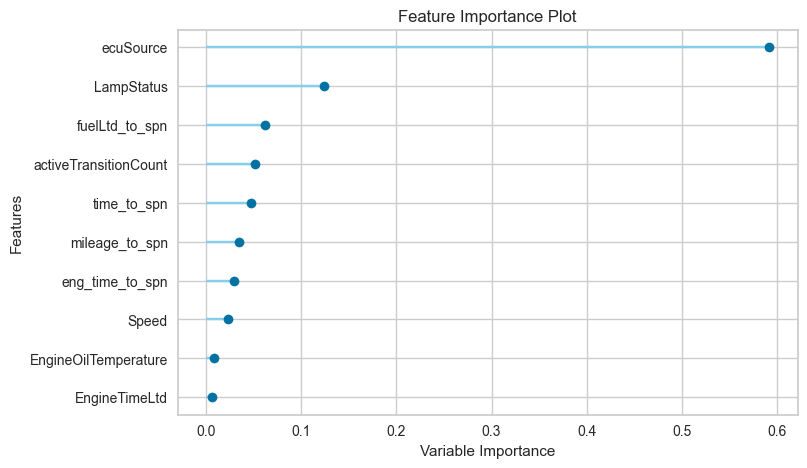

In [32]:
# import libraries
from pycaret.classification import *
import pandas as pd

# create time series split
split = int(len(ml_df)*0.8)
train_data = ml_df[:split]
test_data = ml_df[split:]

# setup pycaret
clf = setup(data=train_data, target='target', session_id=123, fold_strategy='timeseries')

# train model, compare_models() seems to get stuck for some reason
#best_model = compare_models()
model = create_model('gbc')

# plot feature importance
plot_model(model, plot='feature')

In [33]:
# find the first occurrence of spn = 5246 for each EquipmentID
earliest_timestamps = fault_diag_filtered.loc[fault_diag_filtered['spn'] == 5246] \
    .groupby('EquipmentID')['EventTimeStamp'].first()

# create a new column with the time difference in hours between each row and the first occurrence of spn = 5246 for each EquipmentID
fault_diag_filtered['time_diff'] = (fault_diag_filtered['EventTimeStamp'] - fault_diag_filtered['EquipmentID'].map(earliest_timestamps)) \
    .dt.total_seconds() / 3600

# filter the dataframe to keep only the rows where the time difference is less than or equal to 24 hours
filtered_spn = fault_diag_filtered.loc[(fault_diag_filtered['EquipmentID'].isin(earliest_timestamps.index)) 
    & (fault_diag_filtered['time_diff'] >= -24)
    & (fault_diag_filtered['time_diff'] <= 0)]
filtered_spn

,RecordID,ESS_Id,EventTimeStamp,eventDescription,ecuModel,ecuMake,ecuSource,spn,fmi,activeTransitionCount,EquipmentID,Latitude,Longitude,AcceleratorPedal,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,EngineRpm,EngineTimeLtd,FuelLevel,FuelLtd,FuelRate,FuelTemperature,IgnStatus,IntakeManifoldTemperature,LampStatus,Speed,Throttle,TurboBoostPressure,mileage_to_spn,overall_avg_mileage,time_to_spn,overall_avg_time,eng_time_to_spn,overall_avg_eng_time,fuelLtd_to_spn,overall_avg_fuelLtd,target,time_diff
0,5713,1070644,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,4344,5,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.00000,NaN,13.63,0.0,178390.496803,0,529,0.00,3932.941477,0.000000,25003.715213,0,0.000000
1,5714,1070646,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,5246,0,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.00000,NaN,13.63,0.0,178390.496803,0,529,0.00,3932.941477,0.000000,25003.715213,0,0.000000
2,5715,1070647,2015-02-25 13:53:08,Condition Exists Engine Protection Torque Derate,unknown,unknown,0,1569,31,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.00000,NaN,13.63,0.0,178390.496803,0,529,0.00,3932.941477,0.000000,25003.715213,1,0.000000
3,5716,1070648,2015-02-25 13:53:08,Low (Severity Medium) Catalyst Tank Temperature,unknown,unknown,0,3031,18,1,1329,39.399583,-82.974768,0.0,14.2825,483744.4,204.8,34.0,22.62,220.7188,898.375,9337.00,70.0,72585.630126,5.111745,NaN,True,100.4,22527.0,0.00000,NaN,13.63,0.0,178390.496803,0,529,0.00,3932.941477,0.000000,25003.715213,0,0.000000
72,84717,2909659,2015-06-11 16:56:54,Not Reporting Data Catalyst Dosing Unit Input ...,unknown,unknown,49,50353,0,2,1339,38.392546,-82.422546,0.0,14.2100,581309.0,185.0,13.0,16.24,209.4688,649.625,11008.00,54.8,89147.236496,0.726475,NaN,True,165.2,2.0,0.00000,NaN,0.58,35449.3,178390.496803,110,529,721.20,3932.941477,5679.170774,25003.715213,0,-22.641111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170513,311407,6322249,2015-12-14 18:25:46,Incorrect Data J1939 Network #1 Primary Vehicl...,unknown,unknown,49,5246,19,3,305,35.196203,-85.814722,0.0,13.7750,191889.2,197.6,0.0,130.50,222.4063,1626.500,4195.90,76.8,29591.232405,0.000000,104.0,True,113.0,255.0,46.49119,0.0,28.71,94694.8,178390.496803,296,529,2106.90,3932.941477,14288.670035,25003.715213,0,0.000000
171292,1053620,60904453,2018-09-07 05:45:39,Data Drifted High Aftertreatment 1 Outlet NOx,6X1u13D1500000000,CMMNS,0,3226,20,1,306,36.167777,-86.529120,0.0,14.4275,303989.6,183.2,13.0,38.86,214.3062,1327.375,9388.30,64.0,42183.917866,1.492577,32.0,True,104.0,17407.0,65.39931,30.4,0.87,193243.3,178390.496803,1225,529,7191.85,3932.941477,27359.771082,25003.715213,0,-5.616944
171293,1053622,60904613,2018-09-07 05:48:43,Condition Exists NOx limits exceeded due to In...,6X1u13D1500000000,CMMNS,0,4094,31,1,306,36.169907,-86.587731,0.0,14.4275,303992.9,185.0,85.0,38.28,212.2813,1319.750,9388.35,62.8,42184.182038,15.480530,32.0,True,116.6,18431.0,64.72940,0.0,21.46,193243.3,178390.496803,1225,529,7191.85,3932.941477,27359.771082,25003.715213,0,-5.565833
171294,1053642,60909415,2018-09-07 06:47:05,Condition Exists Engine Protection Torque Derate,6X1u13D1500000000,CMMNS,0,1569,31,1,306,36.173240,-86.776990,0.0,14.5000,304007.1,183.2,14.0,23.20,193.3813,599.125,9389.15,67.2,42186.163328,0.515137,32.0,True,145.4,18431.0,0.00000,0.0,0.58,193243.3,178390.496803,1225,529,7191.85,3932.941477,27359.771082,25003.715213,1,-4.593056


In [34]:
filtered_spn.groupby(['spn', 'fmi', 'eventDescription']).size().reset_index(name='count').sort_values('count', ascending=False).head(20)

,spn,fmi,eventDescription,count
32,1569,31,Condition Exists Engine Protection Torque Derate,206
9,96,3,High Voltage (Fuel Level),169
12,111,17,Low (Severity Low) Engine Coolant Level,140
27,829,3,High Voltage (Left Fuel Level Sensor),106
42,1761,19,Data May Be Invalid Catalyst Tank Level,42
69,3362,31,Condition Exists Catalyst Dosing Unit Input Lines,42
37,1761,9,Abnormal Update Rate Catalyst Tank Level,38
71,3364,9,Abnormal Update Rate Catalyst Tank Reagent Qua...,34
30,929,9,Abnormal Update Rate Tire Location,29
47,3031,9,Abnormal Update Rate Catalyst Tank Temperature,23


In [ ]:
interpolated = fault_diag_filtered.interpolate(method='ffill', axis=0)
interpolated

In [ ]:
interpolated.isnull().sum()

In [ ]:
#interpolated = fault_diag_filtered.interpolate(method='bfill', axis=0)

In [ ]:
#interpolated.isnull().sum()

In [ ]:
#fault_diag_filtered = fault_diag_filtered.replace(',', '.', regex=True)

# explicitly require this experimental feature
#from sklearn.experimental import enable_iterative_imputer 
# now you can import normally from sklearn.impute
#from sklearn.impute import IterativeImputer

# create a new DataFrame with only the numeric columns
#dropped_columns = ['EventTimeStamp', 'eventDescription', 'ecuModel', 'ecuMake', 'LocationTimeStamp', 'IgnStatus']
#numeric_data = fault_diag_filtered.drop(dropped_columns, axis=1)

# impute missing values
#imputer = IterativeImputer(max_iter=10, random_state=0)
#imputed_data = pd.DataFrame(imputer.fit_transform(numeric_data), columns=numeric_data.columns)

# select only the columns you want to keep from the original DataFrame
#keep_columns = ['RecordID', 'EventTimeStamp', 'eventDescription', 'ecuModel', 'ecuMake', 'LocationTimeStamp', 'IgnStatus']

# merge the selected columns with the imputed data
#imputed_df = pd.merge(fault_diag_filtered[keep_columns], imputed_data, on='RecordID', how='left')
#imputed_df

In [ ]:
# split location time stamp column
# convert the column to datetime format
interpolated['EventTimeStamp'] = pd.to_datetime(interpolated['EventTimeStamp'],format='%Y-%m-%d %H:%M:%S' )

# extract the date and time components into separate columns
interpolated['date'] = interpolated['EventTimeStamp'].dt.date
interpolated['time'] = interpolated['EventTimeStamp'].dt.time

# print the updated DataFrame
interpolated.head()

In [ ]:
sorted_df = interpolated.sort_values(by=['EquipmentID','EventTimeStamp'], ascending=[True, True])
sorted_df

In [ ]:
sorted_df.head()

In [ ]:
def time_to_spn(sorted_df):
    result = []
    for eq_id, eq_df in sorted_df.groupby('EquipmentID'):
        earliest_timestamp = eq_df['EventTimeStamp'].iloc[0]
        spn_timestamp = eq_df.loc[eq_df['spn'] == 5246, 'EventTimeStamp'].iloc[0]
        result.append((eq_id, spn_timestamp - earliest_timestamp))
    return result

time_to_spn_df = pd.DataFrame(time_to_spn(sorted_df), columns=['EquipmentID', 'time_to_spn'])
overall_avg_time = time_to_spn_df['time_to_spn'].mean()
time_to_spn_df['overall_avg_time'] = overall_avg_time
merged_df = pd.merge(sorted_df, time_to_spn_df, on='EquipmentID')
merged_df.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
fault_diag_true.corr()

In [ ]:
sns.heatmap(fault_diag_true.corr());

In [ ]:
fault_diag_derate = fault_diag_true[fault_diag_true['spn'] == 5246]

In [ ]:
fault_diag_derate

In [ ]:
fault_diag_derate.corr()

In [ ]:
sns.heatmap(fault_diag_derate.corr());

In [ ]:
fault_diag_partial_derate = fault_diag_true[(fault_diag_true['spn'] == 1569) & (fault_diag_true['fmi'] == 31)] 

In [ ]:
fault_diag_partial_derate

In [ ]:
fault_diag_partial_derate.corr()

In [ ]:
sns.heatmap(fault_diag_partial_derate.corr());

In [ ]:
#pip install prophet

In [ ]:
#pip install tsfresh